In [7]:
#general tools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3

#data processing tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score
from scipy import stats
import shap
from sklearn.neighbors import KNeighborsRegressor

#model building tools
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from catboost import Pool
import statsmodels.api as sm

#model productionalization tools
import pickle


ModuleNotFoundError: No module named 'shap'

### Import database

In [9]:
#Establish connection with the local trulia housing .db 
conn = sqlite3.connect(r'trulia_sb_house_data.db')

#read the "cleaned data" table from database and store in a pandas dataframe
df = pd.read_sql_query("SELECT * FROM trulia_house_SB_data_cleaned", conn)


In [10]:

df.head()
df.columns


Index(['level_0', 'index', 'price', 'address', 'zip', 'num_bedrooms',
       'num_baths', 'building_sqft', 'year_built', 'lot_area',
       'home_description', 'feature_list', 'house_age', 'has_garage',
       'has_ocean_views', 'has_mountain_views', 'has_pool', 'has_upstairs',
       'has_IV', 'building_sqft_was_missing'],
      dtype='object')

In [12]:
#dropping unneeded columns
df_model=df.drop(['level_0','index', 'address', 'year_built', 'home_description', 'feature_list'],axis=1)

### Feature Engineering

In [13]:
#The only catagorical feature is the zipcode
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[['zip']]).toarray())
enc_df.columns = enc.get_feature_names(['zip'])

df_model = df_model.join(enc_df)
df_model.head()


/Users/dylannguyen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,price,zip,num_bedrooms,num_baths,building_sqft,lot_area,house_age,has_garage,has_ocean_views,has_mountain_views,...,building_sqft_was_missing,zip_93067,zip_93101,zip_93103,zip_93105,zip_93108,zip_93109,zip_93110,zip_93111,zip_93117
0,3.900000,93108,3.0,3.0,2.354,1.00,62.0,0,0,0,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.780000,93105,3.0,2.0,1.395,0.14,73.0,1,0,0,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.350000,93105,3.0,2.0,1.344,0.50,50.0,0,0,0,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.899000,93109,3.0,3.0,2.558,0.50,42.0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.824215,93109,4.0,2.0,1.407,0.14,63.0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
#number of nulls in each column
print(df_model.isnull().sum())

price                        0
zip                          0
num_bedrooms                 0
num_baths                    0
building_sqft                0
lot_area                     0
house_age                    0
has_garage                   0
has_ocean_views              0
has_mountain_views           0
has_pool                     0
has_upstairs                 0
has_IV                       0
building_sqft_was_missing    0
zip_93067                    0
zip_93101                    0
zip_93103                    0
zip_93105                    0
zip_93108                    0
zip_93109                    0
zip_93110                    0
zip_93111                    0
zip_93117                    0
dtype: int64


### Imputation

In [14]:
#imputation: missing data are filled in to create a complete data matrix that can be analyzed using standard methods
#takes in df and imputes missing numeric values with a knn regressor
def knn_imputer(df):

    #isolate the columns with categorical data
    cat_data = df.select_dtypes(exclude=[np.number])

    #isolate the columns with numeric data
    numeric_data = df.select_dtypes(include=[np.number])

    nan_columns = numeric_data.columns[numeric_data.isna().any()].tolist()
    no_nan_columns = numeric_data.drop(columns=nan_columns).columns

    for col in nan_columns:

        KNN_test_data = numeric_data[numeric_data[col].isna()]
        KNN_train_data = numeric_data.dropna()
        KNN_model = KNeighborsRegressor(n_neighbors=3)
        KNN_model.fit(KNN_train_data[no_nan_columns], KNN_train_data[col])
        numeric_data.loc[numeric_data[col].isna(), col] = KNN_model.predict(
            KNN_test_data[no_nan_columns])

    return pd.concat([numeric_data, cat_data], axis=1)


#df_model=knn_imputer(df_model)
df_model.dropna(subset=['building_sqft'], inplace=True)


In [16]:
#printing to make sure no columns have null values
print(df_model.isnull().sum())


price                        0
zip                          0
num_bedrooms                 0
num_baths                    0
building_sqft                0
lot_area                     0
house_age                    0
has_garage                   0
has_ocean_views              0
has_mountain_views           0
has_pool                     0
has_upstairs                 0
has_IV                       0
building_sqft_was_missing    0
zip_93067                    0
zip_93101                    0
zip_93103                    0
zip_93105                    0
zip_93108                    0
zip_93109                    0
zip_93110                    0
zip_93111                    0
zip_93117                    0
dtype: int64


In [17]:
#Finalized descriptive statistics for each numeric column in df
df_model.describe()

,price,num_bedrooms,num_baths,building_sqft,lot_area,house_age,has_garage,has_ocean_views,has_mountain_views,has_pool,...,building_sqft_was_missing,zip_93067,zip_93101,zip_93103,zip_93105,zip_93108,zip_93109,zip_93110,zip_93111,zip_93117
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.0,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,2.556597,3.609333,3.133333,2.563863,0.724675,54.900000,0.417333,0.118667,0.200000,0.242667,...,0.0,0.001333,0.061333,0.105333,0.192000,0.189333,0.084000,0.113333,0.110667,0.142667
std,1.790440,0.955998,1.356715,1.409905,1.401334,23.990917,0.493448,0.323612,0.400267,0.428981,...,0.0,0.036515,0.240101,0.307187,0.394136,0.392035,0.277573,0.317211,0.313928,0.349966
min,0.437500,2.000000,2.000000,0.668000,0.000002,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.335000,3.000000,2.000000,1.564000,0.169995,38.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.860250,4.000000,3.000000,2.189500,0.230002,59.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.047500,4.000000,4.000000,3.043750,0.800000,66.000000,1.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.815000,9.000000,11.000000,10.823000,15.000000,122.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### PCA & Cluster Analysis

In [18]:
from sklearn.decomposition import PCA

PCA_cols = ['num_bedrooms',
            'num_baths', 'building_sqft', 'lot_area',
            'house_age', 'has_garage',
            'has_fireplace', 'has_ocean_views', 'has_mountain_views',
            'has_hope_ranch', 'has_montecito']

PCA_cols = ['num_bedrooms',
            'num_baths', 'building_sqft', 'lot_area', ]

#
X = df_model[PCA_cols]

#scale our x data
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

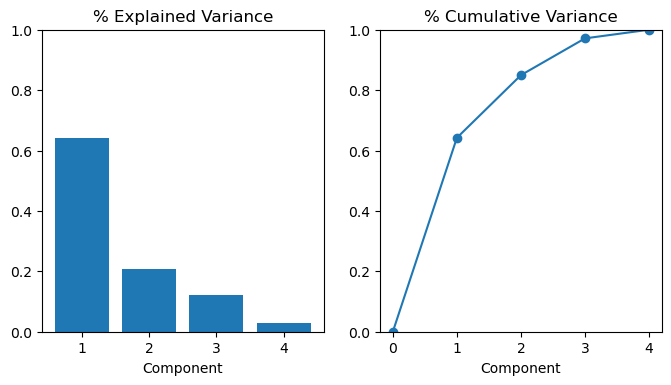

In [19]:
# explained variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


plot_variance(pca)
